In [ ]:
from google.colab import files

files.upload()


import os
os.makedirs("~/.kaggle", exist_ok=True)
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


dataset_name = "balraj98/cityscapes-pix2pix-dataset"
destination_folder = "/content/cityscapes-pix2pix"

!kaggle datasets download -d {dataset_name} -p {destination_folder}
!unzip -q {destination_folder}/*.zip -d {destination_folder}


Saving kaggle.json to kaggle.json
mv: cannot move 'kaggle.json' to '/root/.kaggle/': Not a directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/balraj98/cityscapes-pix2pix-dataset
License(s): other
 88% 89.0M/101M [00:01<00:00, 62.2MB/s]
100% 101M/101M [00:01<00:00, 55.8MB/s] 


In [ ]:
from PIL import Image

def process_images(input_folder, output_folder):

    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        if filename.endswith(".jpg"):
            filepath = os.path.join(input_folder, filename)
            img = Image.open(filepath)


            width, height = img.size


            mid = width // 2

            left = img.crop((0, 0, mid, height))
            right = img.crop((mid, 0, width, height))

            base_name = os.path.splitext(filename)[0]
            left.save(os.path.join(output_folder, f"{base_name}_gt.jpg"))
            right.save(os.path.join(output_folder, f"{base_name}_in.jpg"))

train_folder = "/content/cityscapes-pix2pix/train"
val_folder = "/content/cityscapes-pix2pix/val"

train_output = "/content/processed/train"
val_output = "/content/processed/val"


process_images(train_folder, train_output)

process_images(val_folder, val_output)


In [ ]:
import numpy as np

def create_dataset(input_folder):
    data = []
    targets = []

    for filename in sorted(os.listdir(input_folder)):
        if filename.endswith("_in.jpg"):
            base_name = filename.replace("_in.jpg", "")
            input_path = os.path.join(input_folder, filename)
            target_path = os.path.join(input_folder, f"{base_name}_gt.jpg")

            if os.path.exists(target_path):
                input_img = np.array(Image.open(input_path))
                target_img = np.array(Image.open(target_path))

                data.append(input_img)
                targets.append(target_img)


    data = np.array(data)
    targets = np.array(targets)
    return data, targets


train_data, train_targets = create_dataset(train_output)

val_data, val_targets = create_dataset(val_output)



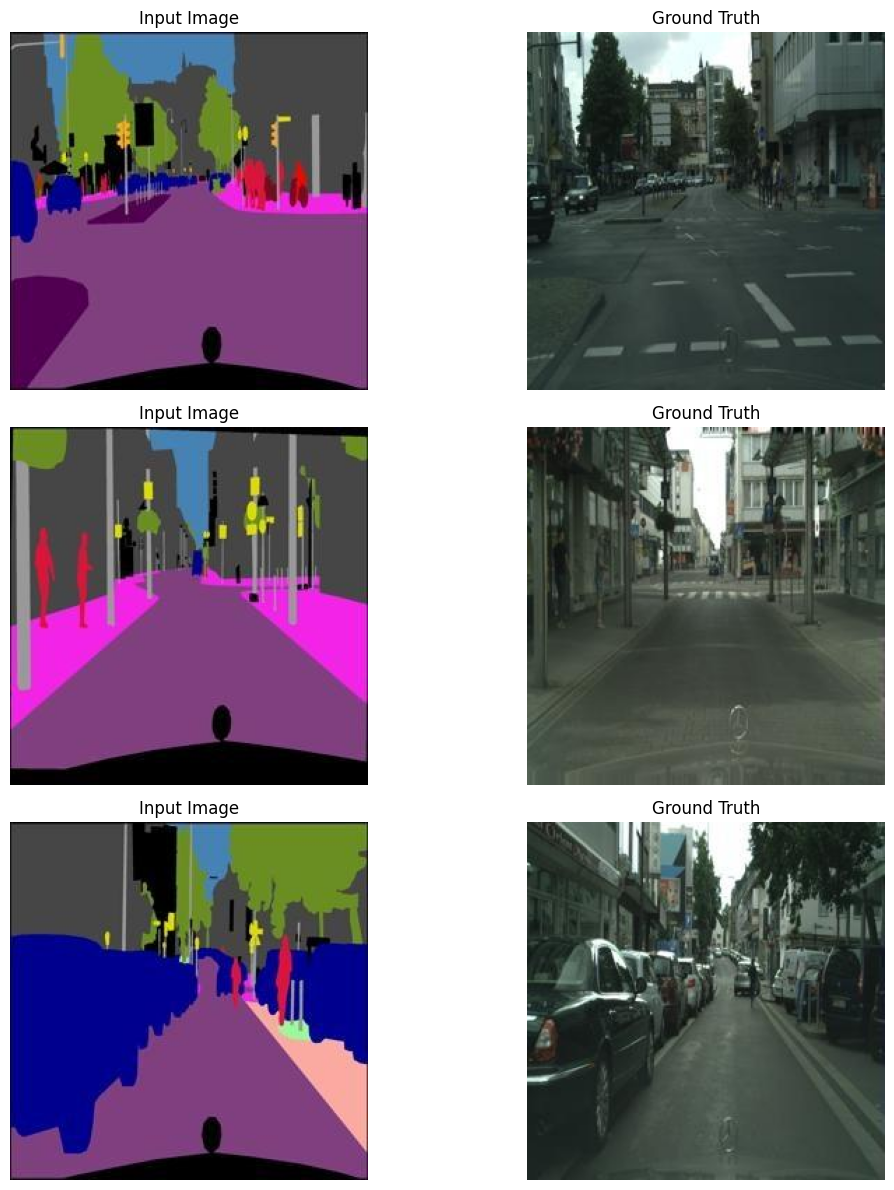

In [ ]:
import matplotlib.pyplot as plt

def visualize_samples(data, targets, num_samples=3):

    plt.figure(figsize=(12, num_samples * 4))
    for i in range(num_samples):
        index = np.random.randint(0, len(data))


        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(data[index])
        plt.title("Input Image")
        plt.axis("off")


        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.imshow(targets[index])
        plt.title("Ground Truth")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


visualize_samples(train_data, train_targets, num_samples=3)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose

In [ ]:
class Pix2PixDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_image = Image.fromarray(self.data[idx])
        target_image = Image.fromarray(self.targets[idx])
        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)
        return {"A": input_image, "B": target_image}

In [ ]:
class DownsamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_batchnorm=True):
        super(DownsamplingBlock, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        if use_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


In [ ]:
class UpsamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_batchnorm=True, dropout=True):
        super(UpsamplingBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True)
        ]
        if use_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        if dropout:
            layers.append(nn.Dropout(0.5))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


In [ ]:
class UNetGenerator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetGenerator, self).__init__()

        self.down1 = DownsamplingBlock(in_channels, 64, use_batchnorm=False)
        self.down2 = DownsamplingBlock(64, 128)
        self.down3 = DownsamplingBlock(128, 256)
        self.down4 = DownsamplingBlock(256, 512)
        self.down5 = DownsamplingBlock(512, 512)
        self.down6 = DownsamplingBlock(512, 512)
        self.down7 = DownsamplingBlock(512, 512)
        self.down8 = DownsamplingBlock(512, 512, use_batchnorm=False)

        self.up1 = UpsamplingBlock(512, 512, dropout=True)
        self.up2 = UpsamplingBlock(1024, 512, dropout=True)
        self.up3 = UpsamplingBlock(1024, 512, dropout=True)
        self.up4 = UpsamplingBlock(1024, 512)
        self.up5 = UpsamplingBlock(1024, 256)
        self.up6 = UpsamplingBlock(512, 128)
        self.up7 = UpsamplingBlock(256, 64)
        self.final = nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8)
        u2 = self.up2(torch.cat([u1, d7], 1))
        u3 = self.up3(torch.cat([u2, d6], 1))
        u4 = self.up4(torch.cat([u3, d5], 1))
        u5 = self.up5(torch.cat([u4, d4], 1))
        u6 = self.up6(torch.cat([u5, d3], 1))
        u7 = self.up7(torch.cat([u6, d2], 1))
        u8 = self.final(torch.cat([u7, d1], 1))
        return self.tanh(u8)

In [ ]:
class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels):
        super(PatchGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
class GANLoss(nn.Module):
    def __init__(self):
        super(GANLoss, self).__init__()
        self.loss = nn.BCEWithLogitsLoss()

    def forward(self, prediction, target_is_real):
        target = torch.ones_like(prediction) if target_is_real else torch.zeros_like(prediction)
        return self.loss(prediction, target)

In [ ]:
def visualize_results(generator, dataloader, device, num_samples=1):
    generator.eval()
    samples = []
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            if i >= num_samples:
                break
            real_a = data['A'].to(device)
            real_b = data['B'].to(device)
            fake_b = generator(real_a)
            samples.append((real_a.cpu(), real_b.cpu(), fake_b.cpu()))


    plt.figure(figsize=(12, num_samples * 4))
    for i, (input_image, target_image, generated_image) in enumerate(samples):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(input_image[0].permute(1, 2, 0) * 0.5 + 0.5)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(target_image[0].permute(1, 2, 0) * 0.5 + 0.5)
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(generated_image[0].permute(1, 2, 0) * 0.5 + 0.5)
        plt.title("Generated Image")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    generator.train()




Hyper-Parameters:

 * lr=0.0001
 * num_epochs=50
 * lambda_l1=100.0
 * batch_size=20

Epoch [1/50], Generator Loss: 27.8635, Discriminator Loss: 0.1085
Epoch [2/50], Generator Loss: 18.2554, Discriminator Loss: 0.0511
Epoch [3/50], Generator Loss: 16.9281, Discriminator Loss: 0.1514
Epoch [4/50], Generator Loss: 17.0188, Discriminator Loss: 0.0956
Epoch [5/50], Generator Loss: 17.2176, Discriminator Loss: 0.1331
Epoch [6/50], Generator Loss: 17.6432, Discriminator Loss: 0.0819
Epoch [7/50], Generator Loss: 18.4475, Discriminator Loss: 0.1065
Epoch [8/50], Generator Loss: 18.5694, Discriminator Loss: 0.1122
Epoch [9/50], Generator Loss: 17.7309, Discriminator Loss: 0.1524
Epoch [10/50], Generator Loss: 18.4715, Discriminator Loss: 0.1421


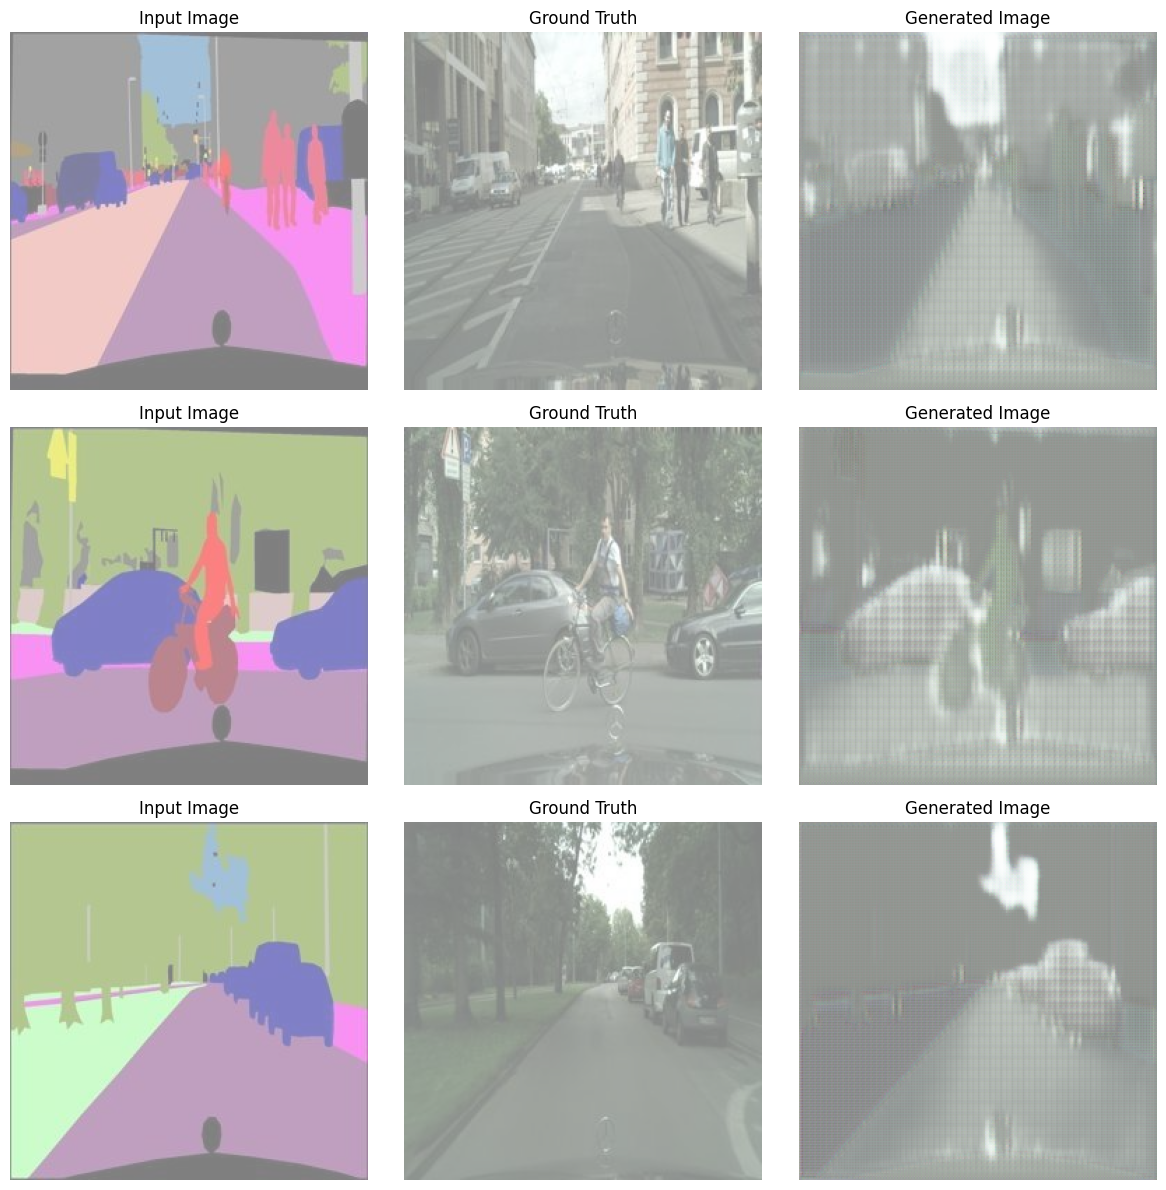

Epoch [11/50], Generator Loss: 18.1962, Discriminator Loss: 0.1364
Epoch [12/50], Generator Loss: 18.2865, Discriminator Loss: 0.1264
Epoch [13/50], Generator Loss: 17.6828, Discriminator Loss: 0.0987
Epoch [14/50], Generator Loss: 18.9502, Discriminator Loss: 0.1386
Epoch [15/50], Generator Loss: 18.4537, Discriminator Loss: 0.1292
Epoch [16/50], Generator Loss: 18.9859, Discriminator Loss: 0.1070
Epoch [17/50], Generator Loss: 18.5428, Discriminator Loss: 0.1758
Epoch [18/50], Generator Loss: 17.8005, Discriminator Loss: 0.1277
Epoch [19/50], Generator Loss: 17.6265, Discriminator Loss: 0.1053
Epoch [20/50], Generator Loss: 18.6838, Discriminator Loss: 0.1716


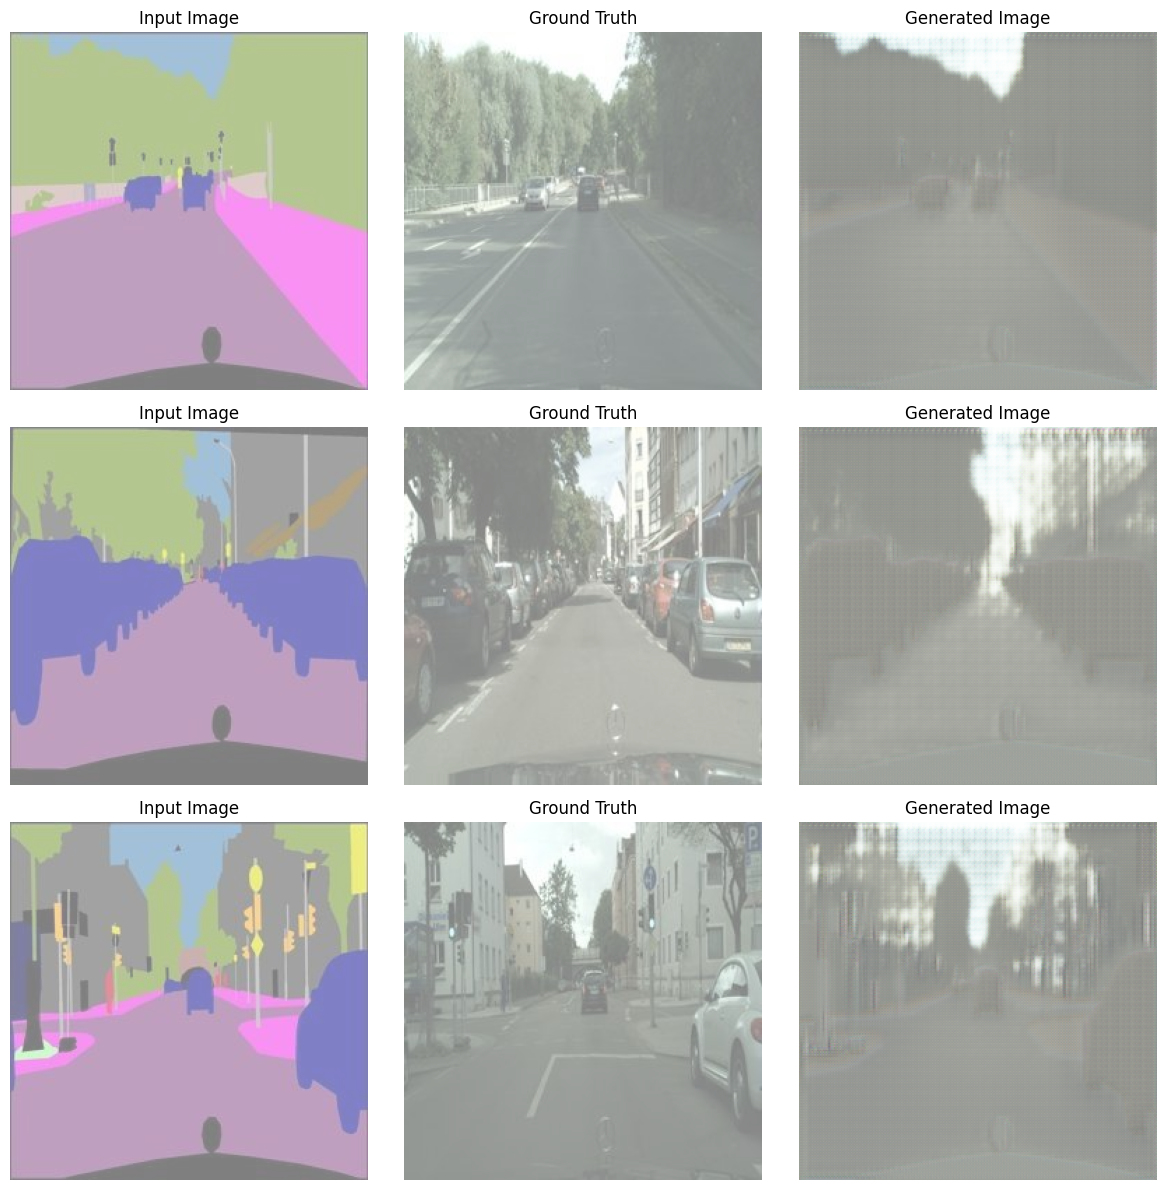

Epoch [21/50], Generator Loss: 17.8056, Discriminator Loss: 0.1488
Epoch [22/50], Generator Loss: 18.0814, Discriminator Loss: 0.1319
Epoch [23/50], Generator Loss: 18.3011, Discriminator Loss: 0.1291
Epoch [24/50], Generator Loss: 18.2607, Discriminator Loss: 0.1246
Epoch [25/50], Generator Loss: 18.1804, Discriminator Loss: 0.1200
Epoch [26/50], Generator Loss: 18.9272, Discriminator Loss: 0.1328
Epoch [27/50], Generator Loss: 18.2724, Discriminator Loss: 0.1183
Epoch [28/50], Generator Loss: 17.8880, Discriminator Loss: 0.1739
Epoch [29/50], Generator Loss: 17.8517, Discriminator Loss: 0.1384
Epoch [30/50], Generator Loss: 18.9769, Discriminator Loss: 0.0918


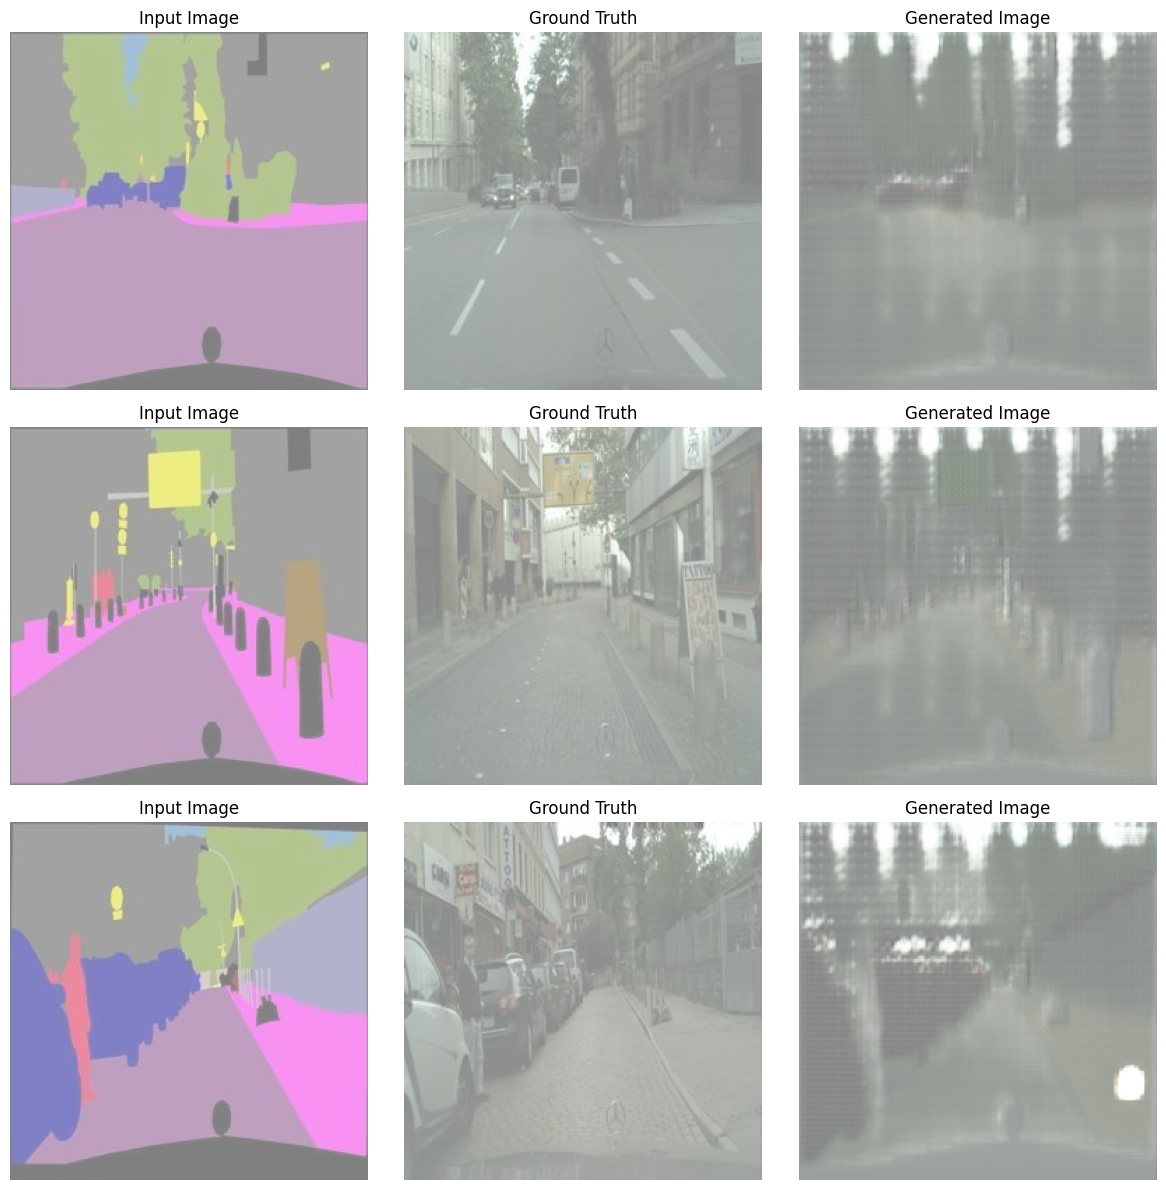

Epoch [31/50], Generator Loss: 19.2589, Discriminator Loss: 0.1033
Epoch [32/50], Generator Loss: 18.9952, Discriminator Loss: 0.1302
Epoch [33/50], Generator Loss: 18.2455, Discriminator Loss: 0.1164
Epoch [34/50], Generator Loss: 18.1502, Discriminator Loss: 0.0900
Epoch [35/50], Generator Loss: 18.4612, Discriminator Loss: 0.1077
Epoch [36/50], Generator Loss: 18.3313, Discriminator Loss: 0.1071
Epoch [37/50], Generator Loss: 18.3636, Discriminator Loss: 0.1163
Epoch [38/50], Generator Loss: 18.4747, Discriminator Loss: 0.1112
Epoch [39/50], Generator Loss: 18.4707, Discriminator Loss: 0.1552
Epoch [40/50], Generator Loss: 18.8116, Discriminator Loss: 0.1128


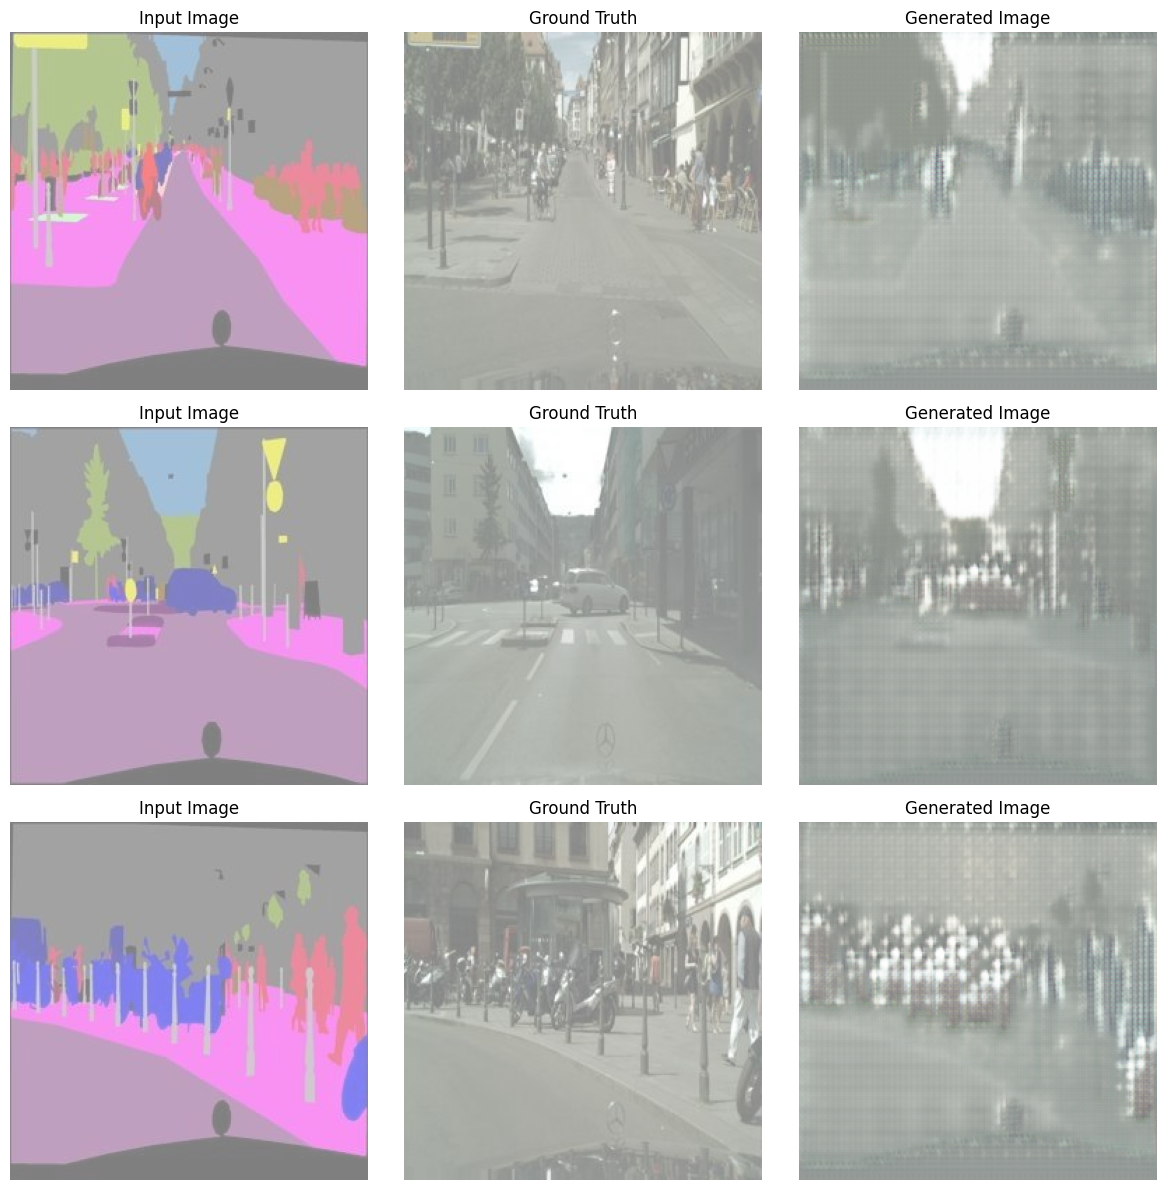

Epoch [41/50], Generator Loss: 18.5763, Discriminator Loss: 0.1416
Epoch [42/50], Generator Loss: 18.1362, Discriminator Loss: 0.0979
Epoch [43/50], Generator Loss: 18.4377, Discriminator Loss: 0.1229
Epoch [44/50], Generator Loss: 18.1810, Discriminator Loss: 0.1148
Epoch [45/50], Generator Loss: 18.7332, Discriminator Loss: 0.1004
Epoch [46/50], Generator Loss: 18.7820, Discriminator Loss: 0.1393
Epoch [47/50], Generator Loss: 19.0487, Discriminator Loss: 0.1334
Epoch [48/50], Generator Loss: 17.8858, Discriminator Loss: 0.0952
Epoch [49/50], Generator Loss: 18.1542, Discriminator Loss: 0.1435
Epoch [50/50], Generator Loss: 18.5648, Discriminator Loss: 0.1574


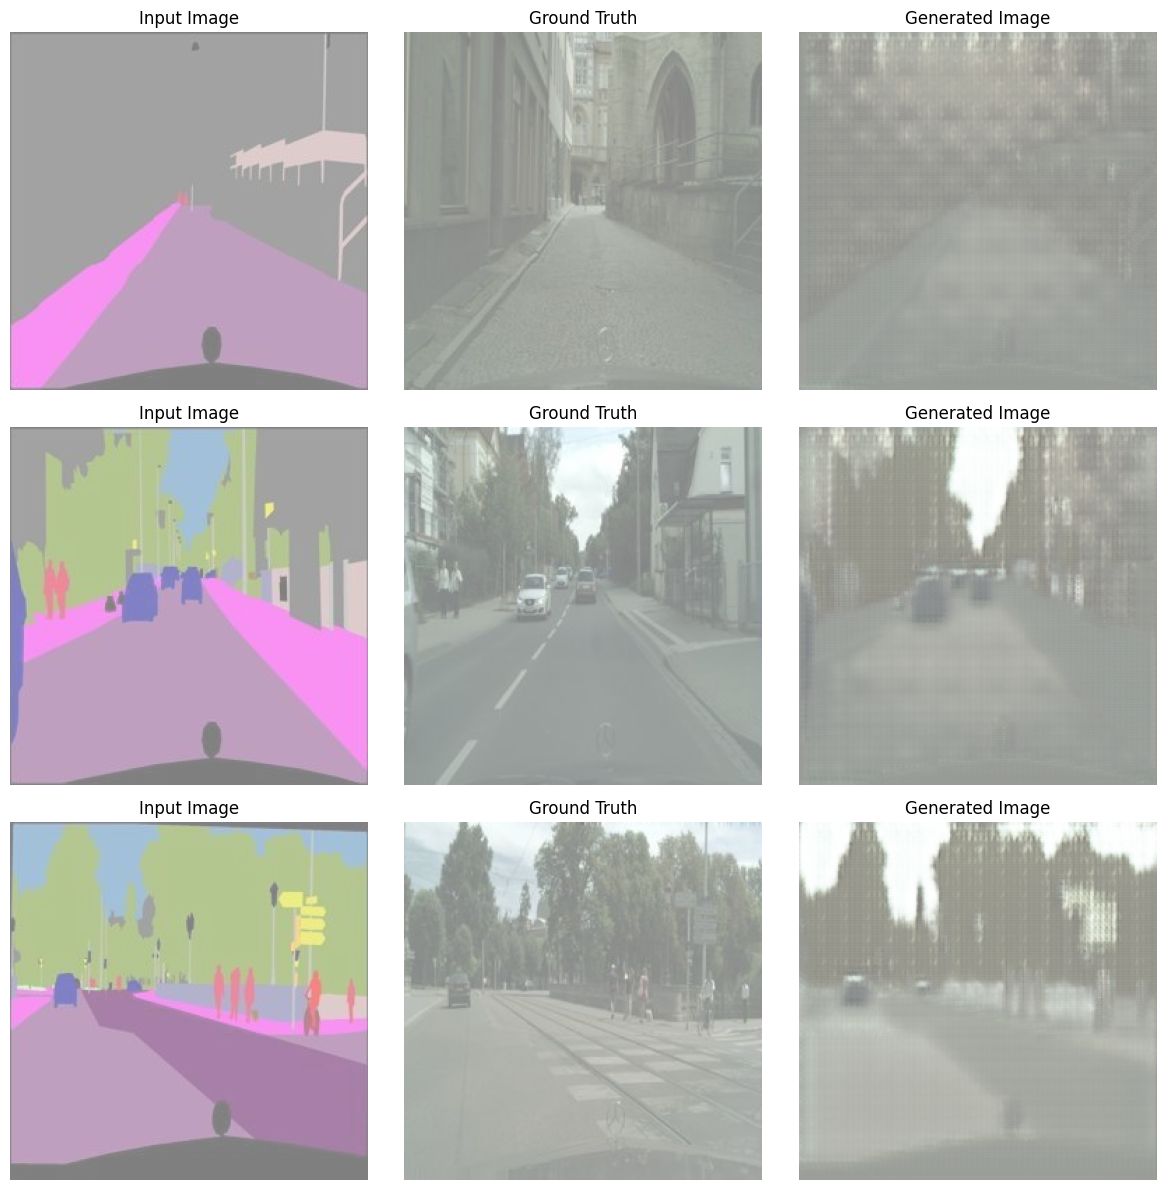

In [ ]:
lr=0.0001
num_epochs=50
lambda_l1=100.0
batch_size=20
generator = UNetGenerator(3, 3)
discriminator = PatchGANDiscriminator(6)
transform = Compose([ToTensor(),
                    #  Normalize((0.5,), (0.5,))
                     ])
dataset = Pix2PixDataset(train_data, train_targets, transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)
criterion_gan = GANLoss().to(device)
criterion_l1 = nn.L1Loss().to(device)
optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

g_losses = []
d_losses = []

for epoch in range(num_epochs):
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    for i, data in enumerate(dataloader):
        real_a = data['A'].to(device)
        real_b = data['B'].to(device)


        optimizer_d.zero_grad()
        fake_b = generator(real_a)
        pred_real = discriminator(torch.cat([real_a, real_b], 1))
        pred_fake = discriminator(torch.cat([real_a, fake_b.detach()], 1))
        loss_d_real = criterion_gan(pred_real, True)
        loss_d_fake = criterion_gan(pred_fake, False)
        loss_d = (loss_d_real + loss_d_fake) * 0.5
        loss_d.backward()
        optimizer_d.step()
        epoch_d_loss += loss_d.item()


        optimizer_g.zero_grad()
        pred_fake = discriminator(torch.cat([real_a, fake_b], 1))
        loss_g_gan = criterion_gan(pred_fake, True)
        loss_g_l1 = criterion_l1(fake_b, real_b) * lambda_l1
        loss_g = loss_g_gan + loss_g_l1
        loss_g.backward()
        optimizer_g.step()
        epoch_g_loss += loss_g.item()

    g_losses.append(epoch_g_loss / len(dataloader))
    d_losses.append(epoch_d_loss / len(dataloader))

    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Generator Loss: {g_losses[-1]:.4f}, Discriminator Loss: {d_losses[-1]:.4f}")

    if (epoch + 1) % 10 == 0:
        visualize_results(generator, dataloader, device, num_samples=3)


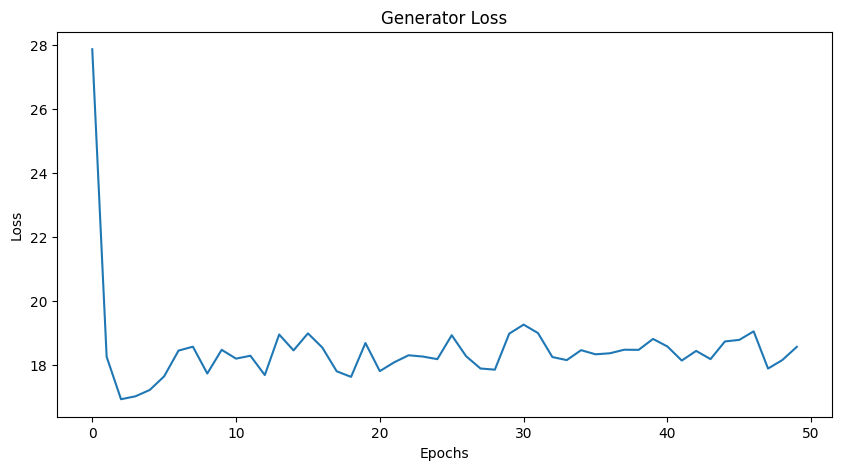

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(g_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Generator Loss")
plt.show()


The generator in Pix2Pix optimizes both adversarial loss and a reconstruction loss, such as L1 loss, to produce realistic images and ensure they closely match the target outputs. A well-trained generator's adversarial loss, like the one shown above, may oscillate slightly, similar to the discriminator, because it is constantly challenged. However, the L1 component usually trends downward, indicating that the generator is learning to better reconstruct the target image. In the case of Pix2Pix, the U-Net generator architecture helps preserve details through skip connections, making the reconstruction process more stable. While some fluctuation is normal, a gradual improvement in the generator's outputs is a more important metric than loss alone. Ultimately, the goal is to achieve a balance where the generator produces high-quality images that consistently challenge the discriminator.

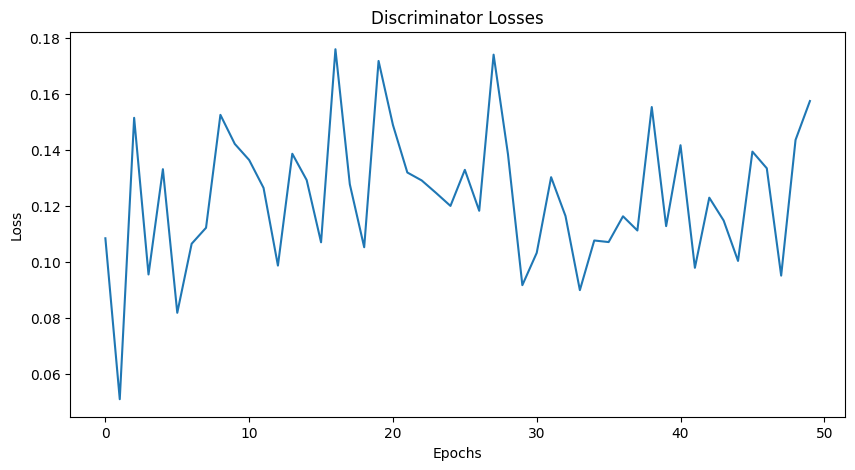

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(d_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Discriminator Losses")
plt.show()

In GANs like Pix2Pix, the discriminator's loss often oscillates throughout training, reflecting the adversarial nature of the model. The discriminator's role is to distinguish real images from those generated by the generator, and as the generator improves, the discriminator must continuously adapt. In the graph shwon above, the discriminator's loss fluctuates within a stable range, which is expected and generally indicates balanced training. These oscillations occur because the discriminator becomes more confident when the generator struggles, and less so as the generator starts producing more realistic outputs. In Pix2Pix, the use of a PatchGAN discriminator emphasizes local detail, which makes these fluctuations even more noticeable as the discriminator focuses on patches of the image rather than the entire scene.